In [2]:
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa import tsatools
from dmba import regressionSummary

Amtrak_df = pd.read_csv('‪C:\Users\Michael\Desktop\Amtrak.csv')

In [3]:
Amtrak_df = pd.read_csv(r'C:\Users\Michael\Desktop\Amtrak.csv')

In [4]:
Amtrak_df

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964
...,...,...
154,01/11/2003,2076.054
155,01/12/2003,2140.677
156,01/01/2004,1831.508
157,01/02/2004,1838.006


In [6]:
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format = '%d/%m/%Y')

In [4]:
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index = Amtrak_df.Date,
                        name = 'Ridership')

In [5]:
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq = ridership_ts.index.inferred_freq)

(1300.0, 2300.0)

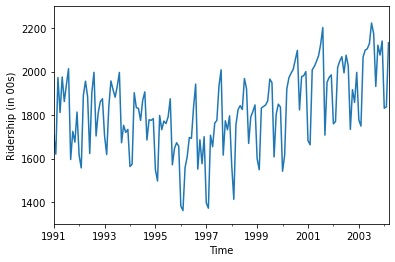

In [6]:
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 00s)')
ax.set_ylim(1300,2300)

In [7]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    


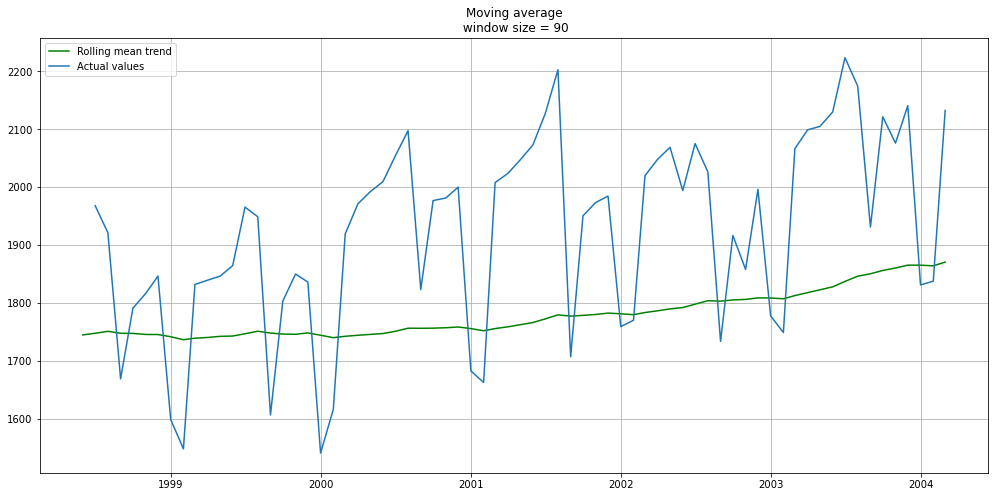

In [8]:
plot_moving_average(ridership_ts, 90)


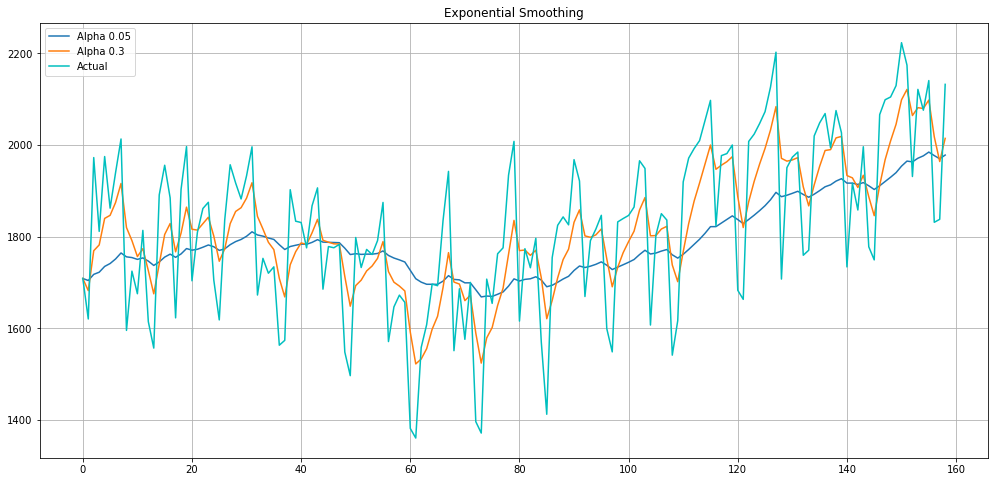

In [9]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(ridership_ts, [0.05, 0.3])

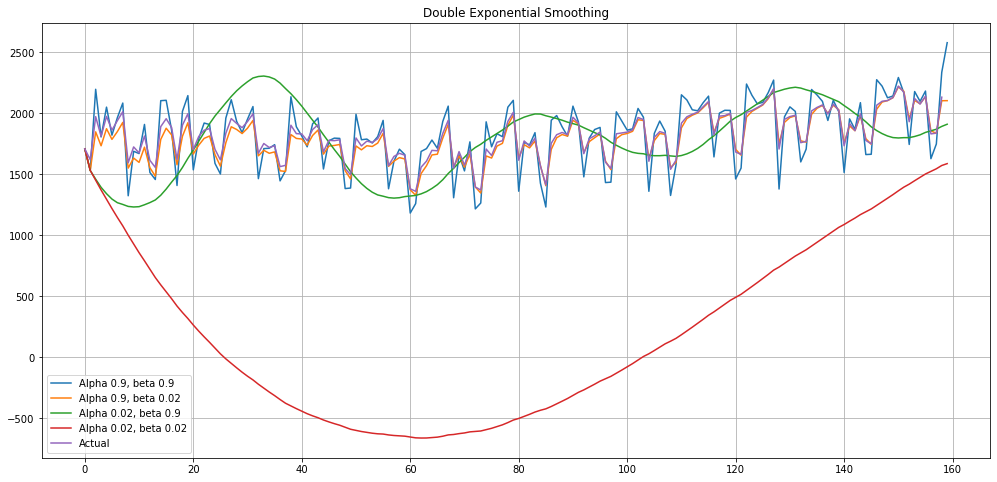

In [10]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(ridership_ts, alphas=[0.9, 0.02], betas=[0.9, 0.02])

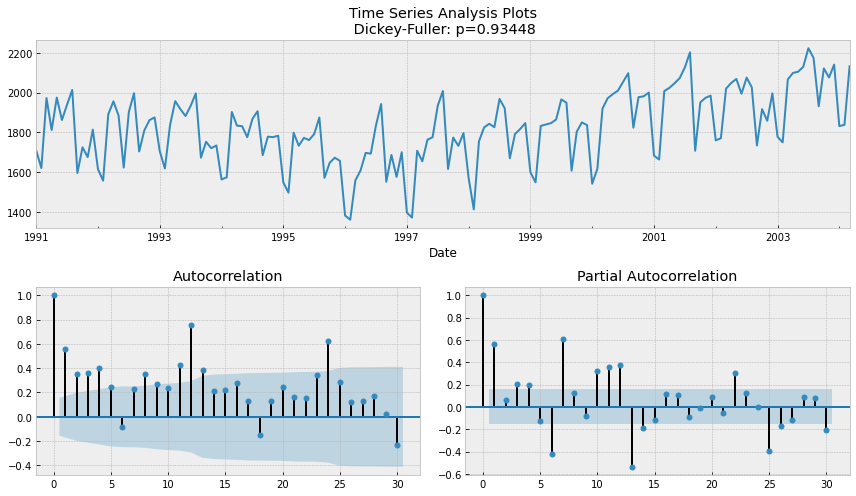

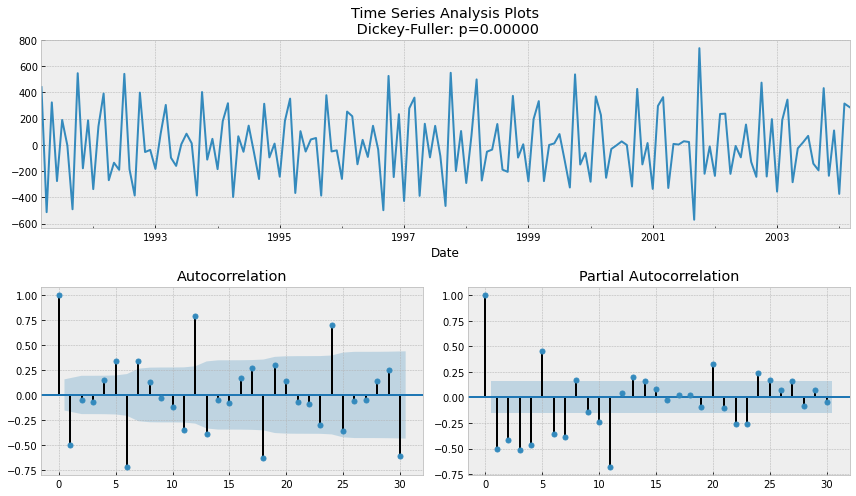

In [12]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ridership_ts, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = ridership_ts - ridership_ts.shift(1)
data_diff2 = data_diff - data_diff.shift(1)

tsplot(data_diff2[2:], lags=30)

In [16]:
#Set initial values and some bounds
from tqdm import tqdm_notebook
from itertools import product
ps = range(0, 5)
d = 2
qs = range(0, 5)
Ps = range(0, 5)
D = 2
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(ridership_ts, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(ridership_ts, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

<ipython-input-16-8ac590e98c82>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\base\model.py:56

C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                                     SARIMAX Results                                      
Dep. Variable:                          Ridership   No. Observations:                  159
Model:             SARIMAX(4, 2, 1)x(4, 2, [], 5)   Log Likelihood                -941.230
Date:                            Tue, 20 Jul 2021   AIC                           1902.460
Time:                                    13:31:22   BIC                           1932.364
Sample:                                01-01-1991   HQIC                          1914.610
                                     - 03-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5356      0.063     -8.454      0.000      -0.660      -0.411
ar.L2         -0.1912      0.070   

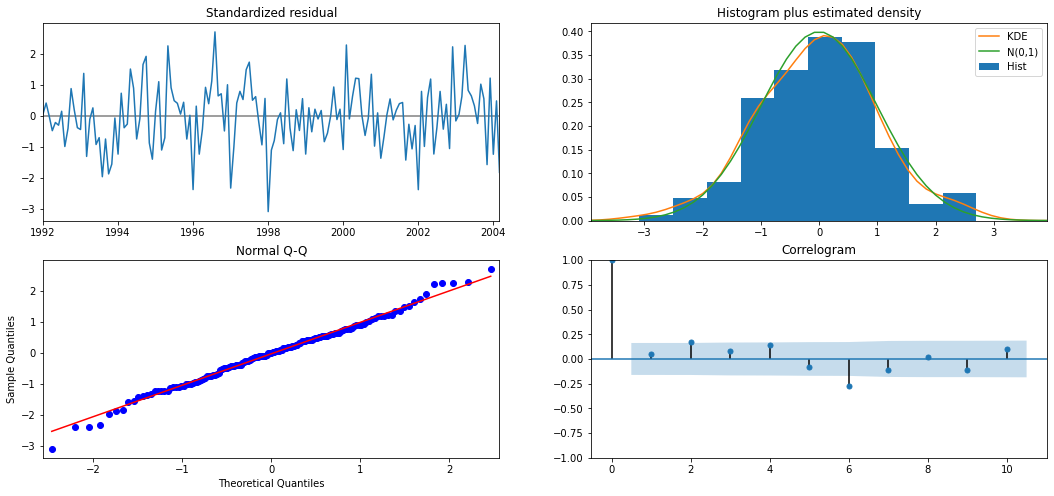

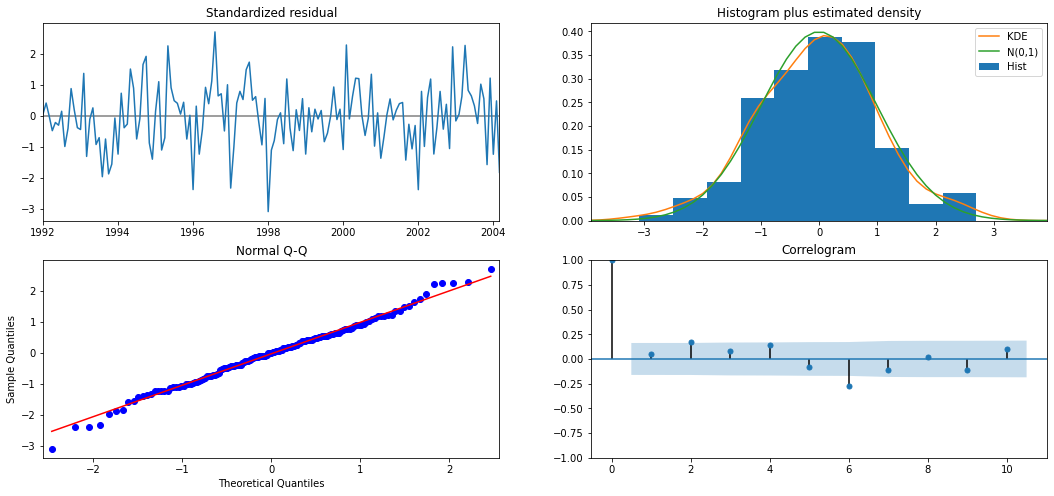

In [19]:
best_model.plot_diagnostics(figsize=(18, 8))

In [57]:
import numpy as np
import scipy.stats as scs
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
data = ridership_ts.copy()
data['Users_box'], lmbda = scs.boxcox(data)
#tsplot(data.Users_box, lags=30)
#print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)


C:\Users\Michael\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


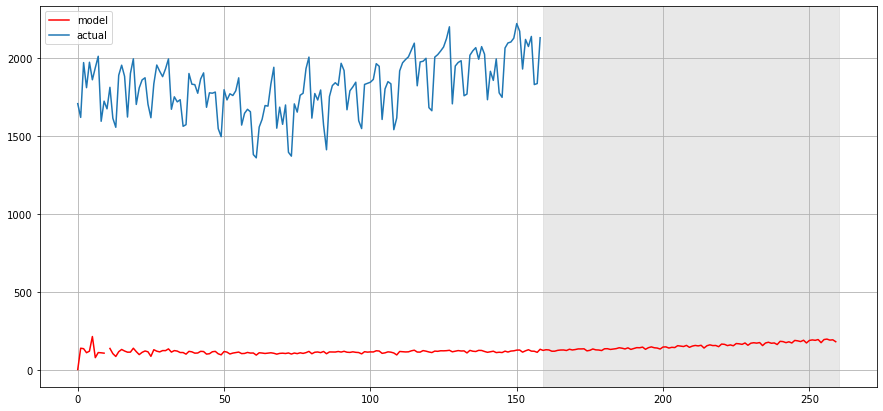

In [63]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = ridership_ts.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
#plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(ridership_ts, data.arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [64]:
ridership_ts

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, Length: 159, dtype: float64

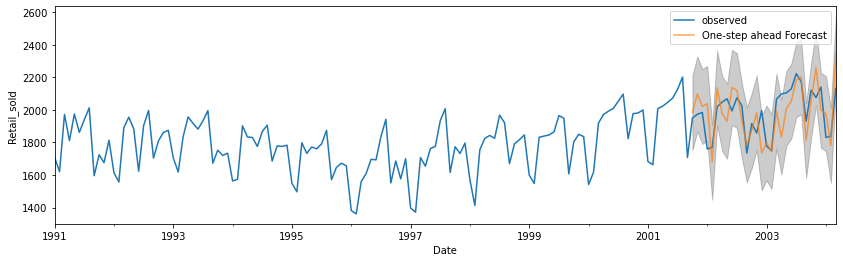

In [70]:
pred = best_model.get_prediction(start=pd.to_datetime('2001-10-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ridership_ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [74]:
y_forecasted = pred.predicted_mean
y_truth = ridership_ts['2001-10-01':]
mae = mean_absolute_error(y_truth,y_forecasted)
#mse = ((y_forecasted - y_truth) ** 2).mean()
print('MAE is {}'.format(round(mae, 2)))
#print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

MAE is 105.94


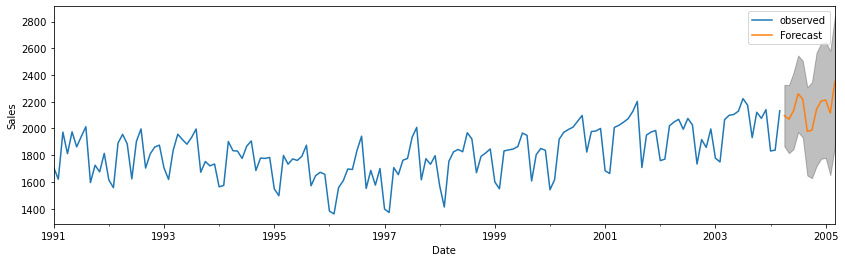

In [73]:
pred_uc = best_model.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = ridership_ts.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

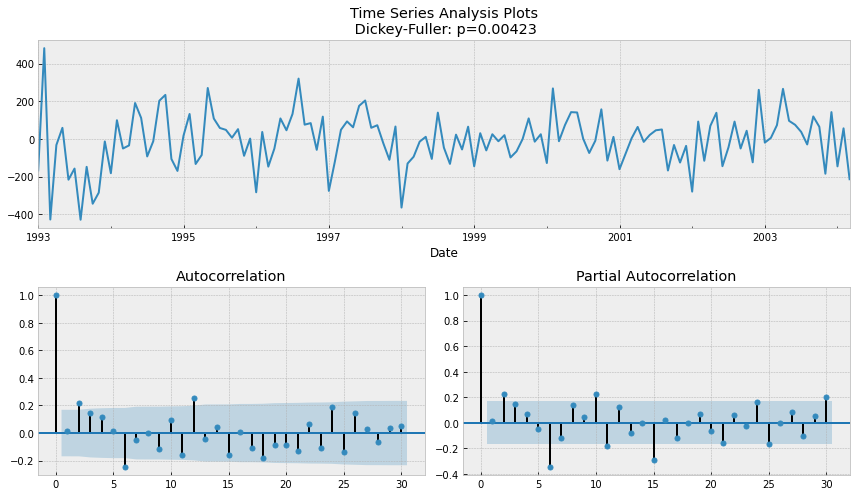

In [38]:
tsplot(best_model.resid[24:], lags=30)

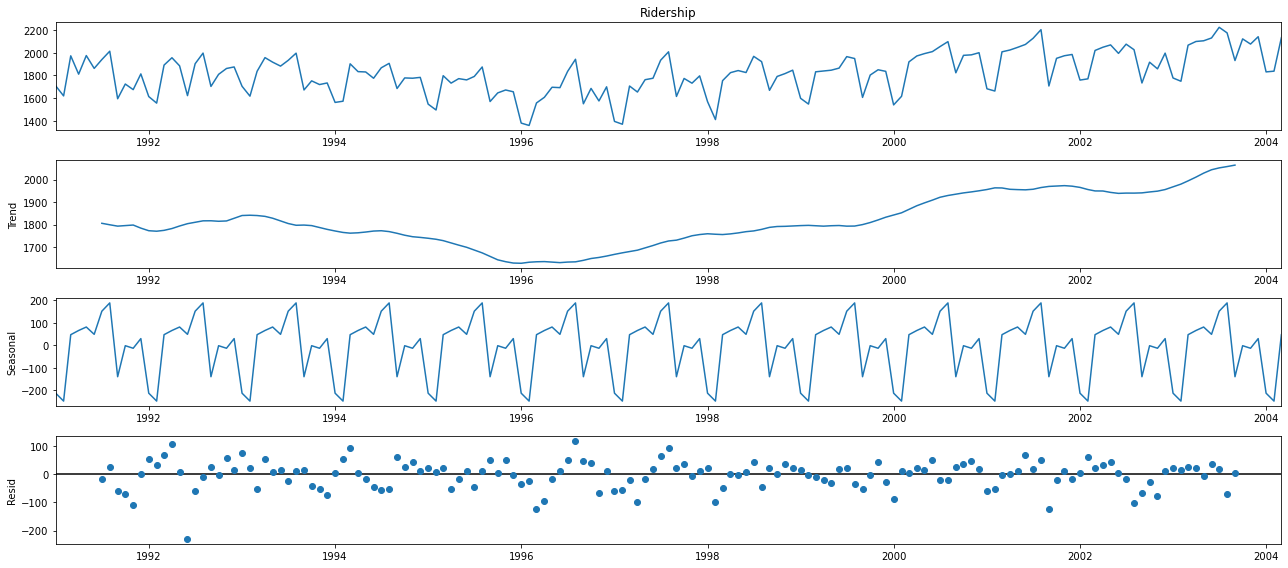

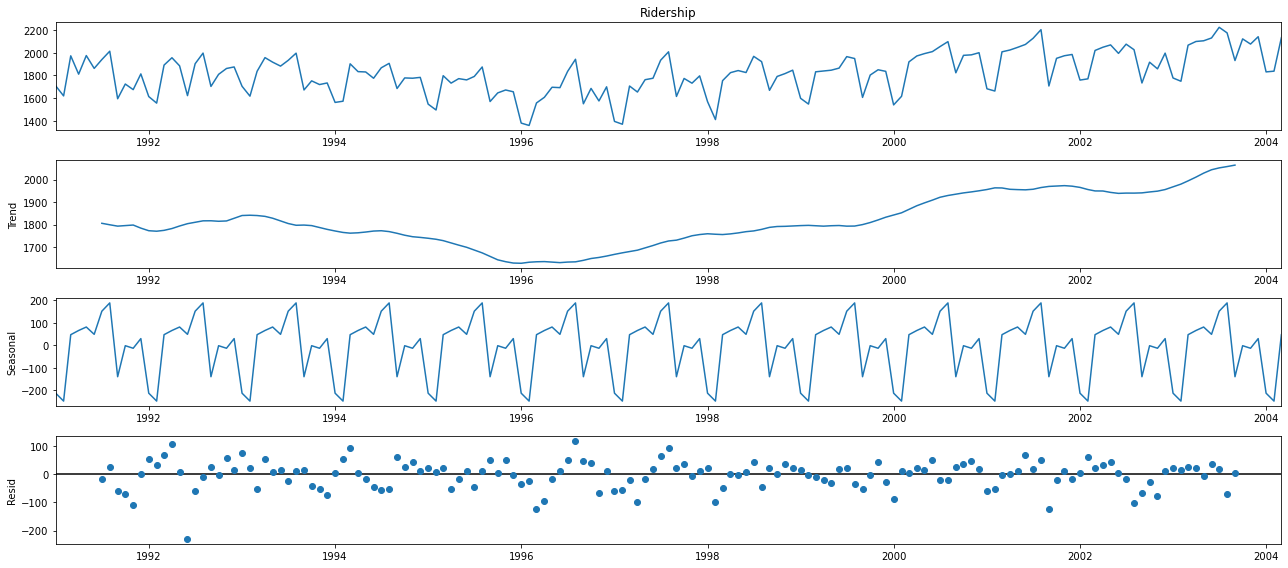

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
seasonal_decompose(ridership_ts).plot()